# Cats vs. Dogs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import os.path as op
import shutil

## Data processing
1. Divide training dataset into train/cats and train/dogs.
2. Create validation dataset.
3. Display one image.
4. Use `ImageDataGenerator` and `augmenting_datagen.flow` to do data augmenting for individual image.
5. Use `augmenting_datagen.flow_from_directory` to randomly choose one image from training set for dogs or cats, then do image augmenting.

In [2]:
# Make data in different folder
data_folder = op.expanduser('cats-dogs')
train_folder = op.join(data_folder, 'train')

def rearrange_folders(folder):
    image_filenames = [op.join(folder, fn) for fn in os.listdir(folder)
                       if fn.endswith('.jpg')]
    if len(image_filenames) == 0:
        return
    print("Rearranging %d images in %s into one subfolder per class..."
          % (len(image_filenames), folder))
    for image_filename in image_filenames:
        subfolder, _ = image_filename.split('.', 1)
        if not op.exists(subfolder):
            os.mkdir(subfolder)
        shutil.move(image_filename, subfolder)

rearrange_folders('cats-dogs/train')

In [3]:
# Take 500 images of cats and 500 images of dogs as validation
n_validation = 500
validation_folder = op.join(data_folder, 'validation')
if not op.exists(validation_folder):
    os.mkdir(validation_folder)
    for class_name in ['dog', 'cat']:
        train_subfolder = op.join(train_folder, class_name)
        validation_subfolder = op.join(validation_folder, class_name)
        print("Populating %s..." % validation_subfolder)
        os.mkdir(validation_subfolder)
        images_filenames = sorted(os.listdir(train_subfolder))
        for image_filename in images_filenames[-n_validation:]:
            shutil.move(op.join(train_subfolder, image_filename),
                        validation_subfolder)
        print("Moved %d images" % len(os.listdir(validation_subfolder)))    

In [4]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img

img = load_img(op.join(train_folder, 'cat', 'cat.249.jpg'))
x = img_to_array(img)

print(x.shape)

Using TensorFlow backend.


(336, 344, 3)


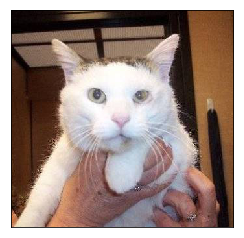

In [5]:
# Display the image
def disp_image(im):
    if (len(im.shape) == 2):
        # Gray scale image 
        plt.imshow(im, cmap='gray')
    else:
        # Color image.
        im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255
        im1 = im1.astype(np.uint8)
        plt.imshow(im1)
        # Remove axis ticks
        plt.xticks([])
        plt.yticks([])
disp_image(x)

In [6]:
# Image augmenting
from keras.preprocessing.image import ImageDataGenerator

augmenting_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    channel_shift_range=9,
    fill_mode='nearest'
)

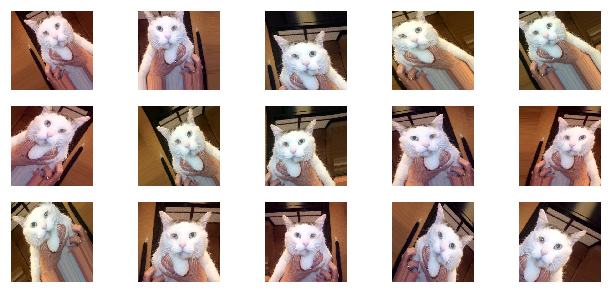

In [7]:
# Plot image augmenting for 1 iamge
plt.figure(figsize=(11, 5))
flow = augmenting_datagen.flow(x[np.newaxis, :, :, :])
for i, x_augmented in zip(range(15), flow):
    plt.subplot(3, 5, i + 1)
    disp_image(x_augmented[0])
    plt.axis('off')

Found 24000 images belonging to 2 classes.


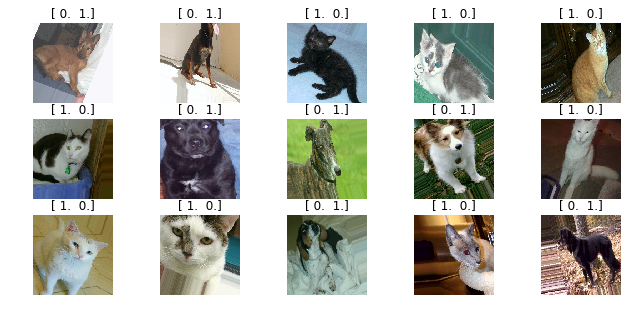

In [8]:
# Augmenting all images
flow_all = augmenting_datagen.flow_from_directory(train_folder, batch_size=1, target_size=(224, 224))

# Display Image with their labels
plt.figure(figsize=(11, 5))
for i, (X, y) in zip(range(15), flow_all):
    plt.subplot(3, 5, i + 1)
    plt.imshow(X[0])
    plt.title (y[0])
    plt.axis('off')
# [0,1] shows the label for dogs while [1,0] shows the label for cats

## Loading a pre-trained network
1.  I used ResNet50 network whichi has 54 parameterized layers (53 convolutional + 1 fully connected for the softmax)
2. Remove the last layer


In [9]:
import keras.backend as K
K.clear_session()

from keras.applications.resnet50 import ResNet50, preprocess_input
full_imagenet_model = ResNet50(weights='imagenet')
print(full_imagenet_model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        input_1[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 112, 112, 64)  0           bn_conv1[0][0]                   
___________________________________________________________________________________________

In [10]:
# Modify model (Remove the last layer)
from keras.models import Model

output = full_imagenet_model.layers[-2].output
base_model = Model(full_imagenet_model.input, output)


In [11]:
# Modify model (Add last layer)
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

top_model = Sequential()
    
top_model.add(Dense(1, input_dim=2048, activation='sigmoid'))
model = Model(base_model.input, top_model(base_model.output))
print (model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        input_1[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 112, 112, 64)  0           bn_conv1[0][0]                   
___________________________________________________________________________________________

In [12]:
# Load data

def preprocess_function(x):
    if x.ndim == 3:
        x = x[np.newaxis, :, :, :]
    return preprocess_input(x)

batch_size = 50

datagen = ImageDataGenerator(preprocessing_function=preprocess_function)

train_flow = datagen.flow_from_directory(
    train_folder,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
)

valgen = ImageDataGenerator(preprocessing_function=preprocess_function)
val_flow = valgen.flow_from_directory(validation_folder, batch_size=batch_size,
                               target_size=(224, 224), shuffle=False,
                               class_mode='binary')



Found 24000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
model.compile(optimizer=Adam(lr=1e-4),
                  loss='binary_crossentropy', metrics=['accuracy'])

steps_per_epoch =  train_flow.n // batch_size
validation_steps =  val_flow.n // batch_size

model.fit_generator(train_flow, steps_per_epoch=steps_per_epoch, validation_data=val_flow,
          validation_steps=validation_steps, epochs=5)

Epoch 1/5
480/480 [==============================] - 29184s - loss: 0.0569 - acc: 0.9790 - val_loss: 0.0613 - val_acc: 0.9780
Epoch 2/5
480/480 [==============================] - 31537s - loss: 0.0150 - acc: 0.9951 - val_loss: 0.0428 - val_acc: 0.9860
Epoch 3/5
480/480 [==============================] - 37454s - loss: 0.0181 - acc: 0.9941 - val_loss: 0.0445 - val_acc: 0.9810
Epoch 4/5
480/480 [==============================] - 28982s - loss: 0.0099 - acc: 0.9970 - val_loss: 0.1019 - val_acc: 0.9780
Epoch 5/5
480/480 [==============================] - 31448s - loss: 0.0108 - acc: 0.9963 - val_loss: 0.0455 - val_acc: 0.9820
